In [1]:
!pip install transformers[torch]
!pip install accelerate
!pip install emoji
!pip install ipywidgets

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

In [3]:
print(torch.__version__)

2.7.0+cu118


In [4]:
!nvidia-smi

Tue Jun 17 22:05:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              7W /   50W |    2415MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import pandas as pd

file_path = r'D:\dataset\Data TA_LABEL.csv'  

df = pd.read_csv(file_path)
df['label_manual'] = df['label_manual'].fillna(0).astype(int)

df.head(10)

,textDisplay,label_manual
0,"Hutan Bojonegoro udah habis di tebang i,,dan d...",0
1,"Jangan khawatir deforestasi!!, kata pak presiden",1
2,"Assalamu&#39;alaikum, izin mengambil salah sat...",1
3,Saya tetap yakin kita terlahir dari nenek moya...,2
4,sekarang rasakan panasnya nggk seperti biasany...,1
5,Sbnr nya hutan milik siapa? Kok berani membaba...,1
6,"demi menyenangkan sahabat jokowi, si haji Is*m...",0
7,Mampus.....Suatu saat kalimantan bakalan gundul,0
8,Kalau orang hidup di kabupaten KKU berdampinga...,0
9,Kalimantan rusak itu akibat ulah pejabat dan o...,0


In [6]:
print(df.shape)

(869, 2)


In [7]:
import re
from bs4 import BeautifulSoup
import emoji

def clean_text(text):
    if isinstance(text, str):
        if re.search(r'<.*?>', text):
            text = BeautifulSoup(text, "html.parser").get_text()

        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
    else:
        text = ""

    return text

df['cleaned_text'] = df['textDisplay'].apply(clean_text)

df = df[df['cleaned_text'] != ""]

print(df[['cleaned_text', 'label_manual']].head(10))

                                        cleaned_text  label_manual
0  Hutan Bojonegoro udah habis di tebang idan di ...             0
1      Jangan khawatir deforestasi kata pak presiden             1
2  Assalamualaikum izin mengambil salah satu klip...             1
3  Saya tetap yakin kita terlahir dari nenek moya...             2
4  sekarang rasakan panasnya nggk seperti biasany...             1
5  Sbnr nya hutan milik siapa Kok berani membabal...             1
6  demi menyenangkan sahabat jokowi si haji Ism j...             0
7         MampusSuatu saat kalimantan bakalan gundul             0
8  Kalau orang hidup di kabupaten KKU berdampinga...             0
9  Kalimantan rusak itu akibat ulah pejabat dan o...             0


In [8]:
output_path = r'D:\dataset\dataset_preprocessing.csv' 
df.to_csv(output_path, index=False)

In [9]:
input_path = r'D:\dataset\dataset_preprocessing.csv'

normalization_dict = {
    'sbnrnya': 'sebenarnya',
    'sbnr': 'sebenarnya',
    'ak': 'aku',
    'gk': 'gak',
    'gak': 'tidak',
    'yg': 'yang',
    'klo': 'kalau',
    'kl': 'kalau',
    'bg': 'banget',
    'gt': 'gitu',
    'gtu': 'gitu',
    'jgn': 'jangan',
    'gpp': 'gapapa',
    'jd': 'jadi',
    'org': 'orang',
    'tak': 'tidak',
    'tgung': 'tanggung',
    'sdh': 'sudah',
    'dah': 'sudah',
    'udh': 'sudah',
    'dh': 'sudah',
    'bgt': 'banget',
    'tmn': 'teman',
    'br': 'baru',
    'lbh': 'lebih',
    'krn': 'karena',
    'SDA': 'sumber daya alam',
    'seblm': 'sebelum',
    'skrg': 'sekarang',
    'skr': 'sekarang',
    'gedhe': 'gede',
    'ngk': 'engga',
    'kn': 'kan',
    'byk': 'banyak',
    'bnyk': 'banyak',
    'gw': 'aku',
    'gue': 'aku',
    'gwk': 'aku',
    'loe': 'kamu',
    'lu': 'kamu',
    'lo': 'kamu',
    'elu': 'kamu',
    'elo': 'kamu',
    'napa': 'kenapa',
    'knp': 'kenapa',
    'mgkn': 'mungkin',
    'gmn': 'gimana',
    'bkn': 'bukan',
    'bs': 'bisa',
    'bisa2': 'bisa-bisa',
    'diaa': 'dia',
    'bgtu': 'begitu',
    'btw': 'ngomong-ngomong',
    'dongg': 'dong',
    'gituu': 'gitu',
    'ntr': 'nanti',
    'msh': 'masih',
    'mauu': 'mau',
    'yakinbgt': 'yakin banget',
    'sampe': 'sampai',
    'mo': 'mau',
    'kek': 'seperti',
    'kyk': 'seperti',
    'ky': 'kayak',
    'ga': 'tidak',
    'enggak': 'tidak',
    'engga': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'tdk': 'tidak',
    'okee': 'oke',
    'okeeee': 'oke',
    'gtw': 'gatau',
    'gatau': 'tidak tahu',
    'gaada': 'tidak ada',
    'gakada': 'tidak ada',
    'gbs': 'tidak bisa',
    'gabisa': 'tidak bisa',
    'gajadi': 'tidak jadi',
    'gapapa': 'tidak apa-apa',
    'gausah': 'tidak usah',
    'udahlah': 'sudah lah',
    'kmn': 'kemana',
    'kmna': 'kemana',
    'sma': 'sama',
    'mls': 'malas',
    'mlas': 'malas',
    'trs2': 'terus-terus',
    'trus2': 'terus-terus',
    'mager': 'malas gerak',
    'drpd': 'daripada',
    'abis': 'habis',
    'mg': 'minggu',
    'biar': 'agar',
    'ampun': 'tidak sanggup',
    'parahh': 'parah',
    'zz': '',
    'zzz': '',
    'wkwk': '',
    'wkwkwk': '',
    'lol': '',
    'hehe': '',
    'haha': '',
    'huhu': '',
    'yaa': 'iya',
    'iyaaa': 'iya',
    'iiya': 'iya',
    'okei': 'oke',
    'okehh': 'oke',
    'heemm': '',
    'tp': 'tapi',
    'dmn': 'dimana',
    'aja': 'saja',
    'dg': 'dengan',
    'dr': 'dari',
    'dpt': 'dapat',
    'karna': 'karena',
    'blm': 'belum',
    'skrng': 'sekarang',
    'ntar': 'nanti',
    'kpn': 'kapan',
    'trs': 'terus',
    'pdhl': 'padahal',
    'kmrn': 'kemarin',
    'km': 'kamu',
    'lg': 'lagi',
    'mknya': 'makanya',
    'trus': 'terus',
    'donk': 'dong',
    'sih': '',
    'deh': '',
    'nya': '',
    'kok': '',
    'hdh': '',
    'cuma': 'hanya',
    'cuman': 'hanya',
    'y': 'ya',
    'thx': 'terima kasih',
    'thnk': 'terima kasih',
    'makasih': 'terima kasih',
    'thanks': 'terima kasih',
    'sm': 'sama',
    'sama2': 'sama-sama',
    'sama2': 'sama-sama',
    'idan': 'dan',
    'pd': 'pada',
    'ya': 'iya',
    'nggk ': 'engga'
}

def normalize_text(text):
    text = text.lower()
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['normalized_text'] = df['cleaned_text'].apply(normalize_text)
print(df[['cleaned_text', 'normalized_text']].head(10))

output_path = r'D:\dataset\cleaned_text.csv'
df[['normalized_text', 'label_manual']].to_csv(output_path, index=False)

                                        cleaned_text  \
0  Hutan Bojonegoro udah habis di tebang idan di ...   
1      Jangan khawatir deforestasi kata pak presiden   
2  Assalamualaikum izin mengambil salah satu klip...   
3  Saya tetap yakin kita terlahir dari nenek moya...   
4  sekarang rasakan panasnya nggk seperti biasany...   
5  Sbnr nya hutan milik siapa Kok berani membabal...   
6  demi menyenangkan sahabat jokowi si haji Ism j...   
7         MampusSuatu saat kalimantan bakalan gundul   
8  Kalau orang hidup di kabupaten KKU berdampinga...   
9  Kalimantan rusak itu akibat ulah pejabat dan o...   

                                     normalized_text  
0  hutan bojonegoro udah habis di tebang dan di t...  
1      jangan khawatir deforestasi kata pak presiden  
2  assalamualaikum izin mengambil salah satu klip...  
3  saya tetap yakin kita terlahir dari nenek moya...  
4  sekarang rasakan panasnya nggk seperti biasany...  
5  sebenarnya  hutan milik siapa  berani membabal... 

In [10]:
import pandas as pd

# Membaca dataset
df = pd.read_csv(r'D:\dataset\cleaned_text.csv')

# Menampilkan jumlah data di awal
print(f"Jumlah data di dataset: {len(df)}")

# Menampilkan distribusi label pada kolom 'label_manual'
print("\nDistribusi label_manual pada dataset:")
print(df['label_manual'].value_counts())

Jumlah data di dataset: 859

Distribusi label_manual pada dataset:
label_manual
0    522
1    289
2     48
Name: count, dtype: int64


In [11]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Membaca dataset
df = pd.read_csv(r'D:\dataset\cleaned_text.csv')

# Membuat folder output jika belum ada
output_folder = r'D:\dataset'
os.makedirs(output_folder, exist_ok=True)

# 1. Bagi dataset menjadi 70% untuk training dan 30% untuk validation
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_manual'])

# 2. Oversampling pada Training Set
df_majority = train_df[train_df['label_manual'] == 0]  # Kelas mayoritas (label = 0)
df_minority_1 = train_df[train_df['label_manual'] == 1]  # Kelas minoritas 1 (label = 1)
df_minority_2 = train_df[train_df['label_manual'] == 2]  # Kelas minoritas 2 (label = 2)

# Oversampling kelas mayoritas dan minoritas agar jumlahnya sama
n_samples = max(df_majority.shape[0], df_minority_1.shape[0], df_minority_2.shape[0])

df_majority_upsampled = resample(df_majority, replace=True, n_samples=n_samples, random_state=42)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=n_samples, random_state=42)
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=n_samples, random_state=42)

# Gabungkan data setelah oversampling
train_upsampled = pd.concat([df_majority_upsampled, df_minority_1_upsampled, df_minority_2_upsampled])

# Cek distribusi label pada training set dan validation set
print(f"Jumlah data untuk training set (setelah oversampling): {len(train_upsampled)}")
print(f"Jumlah data untuk validation set: {len(val_df)}")

# 4. Cek distribusi label pada masing-masing set
print("Distribusi label_manual pada Training Set (setelah oversampling):")
print(train_upsampled['label_manual'].value_counts())

print("Distribusi label_manual pada Validation Set:")
print(val_df['label_manual'].value_counts())

# 5. Simpan dataset
train_output_path = os.path.join(output_folder, 'data_train.csv')
val_output_path = os.path.join(output_folder, 'data_val.csv')

train_upsampled.to_csv(train_output_path, index=False)
val_df.to_csv(val_output_path, index=False)

print(f"Data telah disimpan ke dalam folder 'dataset':\n"
      f"{train_output_path}\n"
      f"{val_output_path}")

Jumlah data untuk training set (setelah oversampling): 1095
Jumlah data untuk validation set: 258
Distribusi label_manual pada Training Set (setelah oversampling):
label_manual
0    365
1    365
2    365
Name: count, dtype: int64
Distribusi label_manual pada Validation Set:
label_manual
0    157
1     87
2     14
Name: count, dtype: int64
Data telah disimpan ke dalam folder 'dataset':
D:\dataset\data_train.csv
D:\dataset\data_val.csv


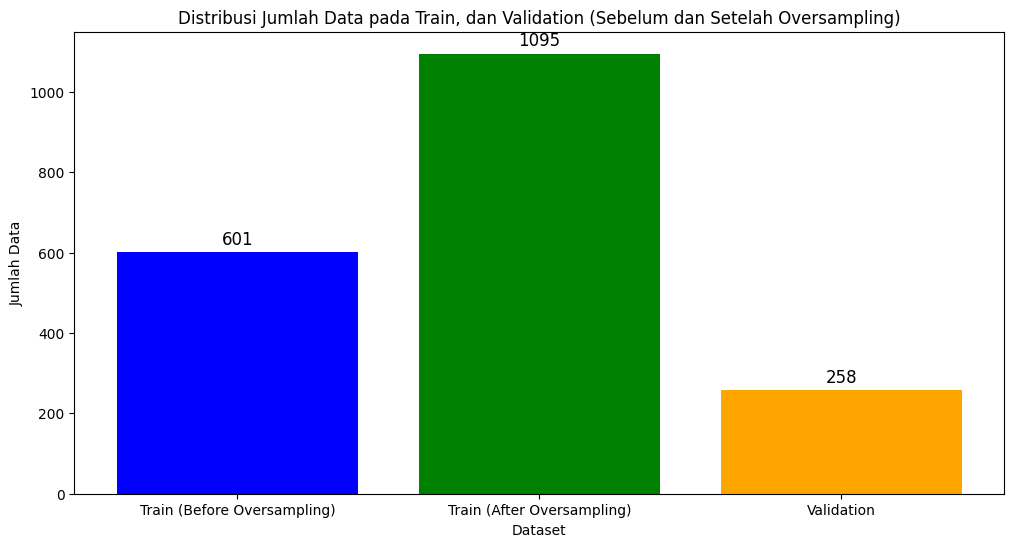

Jumlah data untuk Training Set (sebelum oversampling): 601
Jumlah data untuk Training Set (setelah oversampling): 1095
Jumlah data untuk Validation Set: 258

Distribusi label_manual pada Training Set (sebelum oversampling):
label_manual
0    365
1    202
2     34
Name: count, dtype: int64

Distribusi label_manual pada Training Set (setelah oversampling):
label_manual
0    365
1    365
2    365
Name: count, dtype: int64

Distribusi label_manual pada Validation Set:
label_manual
0    157
1     87
2     14
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt


train_data_count = len(train_upsampled)  
train_data_count_before_upsampling = len(train_df)  
val_data_count = len(val_df)

plt.figure(figsize=(12, 6)) 


labels = ['Train (Before Oversampling)', 'Train (After Oversampling)', 'Validation']
data_counts = [train_data_count_before_upsampling, train_data_count, val_data_count]

plt.bar(labels, data_counts, color=['blue', 'green', 'orange', 'red'])

# jumlah data pada setiap set
for i, count in enumerate(data_counts):
    plt.text(i, count + 10, f'{count}', ha='center', va='bottom', fontsize=12)

# Menambahkan judul dan label
plt.title('Distribusi Jumlah Data pada Train, dan Validation (Sebelum dan Setelah Oversampling)')
plt.xlabel('Dataset')
plt.ylabel('Jumlah Data')
plt.show()

# 2. Cek distribusi label untuk setiap set
print(f"Jumlah data untuk Training Set (sebelum oversampling): {train_data_count_before_upsampling}")
print(f"Jumlah data untuk Training Set (setelah oversampling): {train_data_count}")
print(f"Jumlah data untuk Validation Set: {val_data_count}")


print("\nDistribusi label_manual pada Training Set (sebelum oversampling):")
print(train_df['label_manual'].value_counts())

print("\nDistribusi label_manual pada Training Set (setelah oversampling):")
print(train_upsampled['label_manual'].value_counts())

print("\nDistribusi label_manual pada Validation Set:")
print(val_df['label_manual'].value_counts())



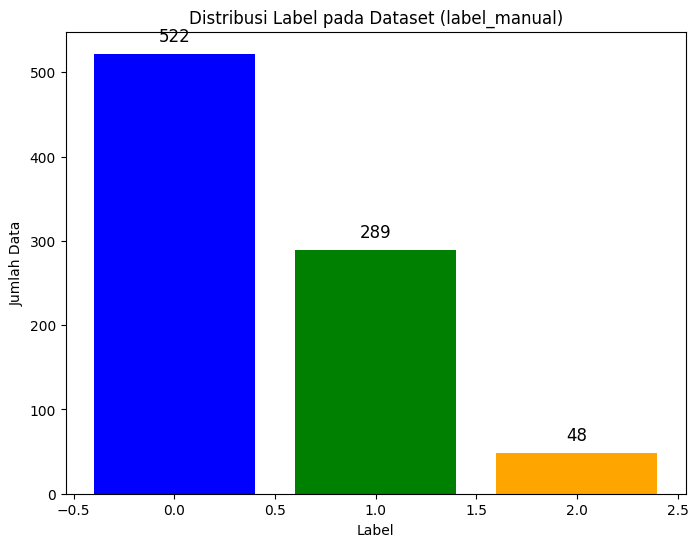


Distribusi label pada dataset:
label_manual
0    522
1    289
2     48
Name: count, dtype: int64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'D:\dataset\cleaned_text.csv'
df = pd.read_csv(file_path)

label_counts = df['label_manual'].value_counts()

# Membuat grafik distribusi label
plt.figure(figsize=(8, 6))

labels = label_counts.index  # Positif, Negatif, Netral
counts = label_counts.values 

plt.bar(labels, counts, color=['blue', 'green', 'orange'])


for i, count in enumerate(counts):
    plt.text(i, count + 10, f'{count}', ha='center', va='bottom', fontsize=12)

# Menambahkan judul dan label
plt.title('Distribusi Label pada Dataset (label_manual)')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')


plt.show()

print("\nDistribusi label pada dataset:")
print(df['label_manual'].value_counts())

In [14]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")


train_df = pd.read_csv(r'D:\dataset\data_train.csv')
val_df = pd.read_csv(r'D:\dataset\data_val.csv')

# Tokenisasi, padding, dan truncation untuk setiap set
def tokenize_text(text):
    if isinstance(text, str) and text.strip() != "":
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,  
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        return input_ids
    else:
        return []

# Tokenisasi untuk train dan validation set
train_df['tokenized_text'] = train_df['normalized_text'].apply(lambda x: tokenize_text(x))
val_df['tokenized_text'] = val_df['normalized_text'].apply(lambda x: tokenize_text(x))

# Menambahkan panjang token untuk masing-masing dataset
train_df['tokenized_length'] = train_df['tokenized_text'].apply(len)
val_df['tokenized_length'] = val_df['tokenized_text'].apply(len)


train_output_path = r'D:\dataset\train_tokenized_indobert.csv'
val_output_path = r'D:\dataset\val_tokenized_indobert.csv'

train_df.to_csv(train_output_path, index=False)
val_df.to_csv(val_output_path, index=False)

print(f"Hasil tokenisasi train disimpan di: {train_output_path}")
print(f"Hasil tokenisasi val disimpan di: {val_output_path}")

print(train_df[['tokenized_text']].head(10))
print(val_df[['tokenized_text']].head(10))

Hasil tokenisasi train disimpan di: D:\dataset\train_tokenized_indobert.csv
Hasil tokenisasi val disimpan di: D:\dataset\val_tokenized_indobert.csv
                                      tokenized_text
0  [tensor(3), tensor(8975), tensor(8439), tensor...
1  [tensor(3), tensor(6336), tensor(2327), tensor...
2  [tensor(3), tensor(25859), tensor(1630), tenso...
3  [tensor(3), tensor(9319), tensor(1540), tensor...
4  [tensor(3), tensor(1485), tensor(4694), tensor...
5  [tensor(3), tensor(3726), tensor(1485), tensor...
6  [tensor(3), tensor(6739), tensor(2037), tensor...
7  [tensor(3), tensor(8975), tensor(8439), tensor...
8  [tensor(3), tensor(1990), tensor(1656), tensor...
9  [tensor(3), tensor(1646), tensor(1646), tensor...
                                      tokenized_text
0  [tensor(3), tensor(26702), tensor(945), tensor...
1  [tensor(3), tensor(1821), tensor(19077), tenso...
2  [tensor(3), tensor(18639), tensor(1994), tenso...
3  [tensor(3), tensor(3720), tensor(18173), tenso...
4  [

In [15]:
print(df.columns)

Index(['normalized_text', 'label_manual'], dtype='object')


In [16]:
# Fungsi untuk membuat attention mask
def create_attention_mask(input_ids):
    attention_mask = [1 if token_id != tokenizer.pad_token_id else 0 for token_id in input_ids]
    return attention_mask

# Terapkan attention mask pada kolom 'tokenized_text' untuk train, validation, 
train_df['attention_mask'] = train_df['tokenized_text'].apply(lambda x: create_attention_mask(x))
val_df['attention_mask'] = val_df['tokenized_text'].apply(lambda x: create_attention_mask(x))

# Cek hasilnya
print(train_df[['tokenized_text', 'attention_mask']].head())
print(val_df[['tokenized_text', 'attention_mask']].head())

# Simpan data yang sudah ditambahkan attention mask
train_output_path = r'D:\dataset\train_with_attention_mask.csv'
val_output_path = r'D:\dataset\val_with_attention_mask.csv'

train_df.to_csv(train_output_path, index=False)
val_df.to_csv(val_output_path, index=False)

print(f"Data dengan attention mask telah disimpan di:\n"
      f"{train_output_path}\n"
      f"{val_output_path}\n")

                                      tokenized_text  \
0  [tensor(3), tensor(8975), tensor(8439), tensor...   
1  [tensor(3), tensor(6336), tensor(2327), tensor...   
2  [tensor(3), tensor(25859), tensor(1630), tenso...   
3  [tensor(3), tensor(9319), tensor(1540), tensor...   
4  [tensor(3), tensor(1485), tensor(4694), tensor...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
                                      tokenized_text  \
0  [tensor(3), tensor(26702), tensor(945), tensor...   
1  [tensor(3), tensor(1821), tensor(19077), tenso...   
2  [tensor(3), tensor(18639), tensor(1994), tenso...   
3  [tensor(3), tensor(3720), tensor(18173), tenso...   
4  [tensor(3), tensor(15089), tensor(5360), tenso... 

In [17]:
import torch

# Fungsi untuk mengonversi tokenized_text dan attention_mask ke tensor
def convert_to_tensor(input_ids, attention_mask):
    input_ids_tensor = input_ids.detach().clone() if isinstance(input_ids, torch.Tensor) else torch.tensor(input_ids)
    attention_mask_tensor = attention_mask.detach().clone() if isinstance(attention_mask, torch.Tensor) else torch.tensor(attention_mask)
    return input_ids_tensor, attention_mask_tensor

train_df['input_ids_tensor'], train_df['attention_mask_tensor'] = zip(*train_df.apply(lambda row: convert_to_tensor(row['tokenized_text'], row['attention_mask']), axis=1))
val_df['input_ids_tensor'], val_df['attention_mask_tensor'] = zip(*val_df.apply(lambda row: convert_to_tensor(row['tokenized_text'], row['attention_mask']), axis=1))
# Cek hasilnya
print(train_df[['tokenized_text', 'attention_mask', 'input_ids_tensor', 'attention_mask_tensor']].head())
print(val_df[['tokenized_text', 'attention_mask', 'input_ids_tensor', 'attention_mask_tensor']].head())

                                      tokenized_text  \
0  [tensor(3), tensor(8975), tensor(8439), tensor...   
1  [tensor(3), tensor(6336), tensor(2327), tensor...   
2  [tensor(3), tensor(25859), tensor(1630), tenso...   
3  [tensor(3), tensor(9319), tensor(1540), tensor...   
4  [tensor(3), tensor(1485), tensor(4694), tensor...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                    input_ids_tensor  \
0  [tensor(3), tensor(8975), tensor(8439), tensor...   
1  [tensor(3), tensor(6336), tensor(2327), tensor...   
2  [tensor(3), tensor(25859), tensor(1630), tenso...   
3  [tensor(3), tensor(9319), tensor(1540), tensor...   
4  [tensor(3), tensor(1485), tensor(4694), ten

In [18]:
print(f"Jumlah data untuk training set: {len(train_df)}")
print(f"Jumlah data untuk validation set: {len(val_df)}")

Jumlah data untuk training set: 1095
Jumlah data untuk validation set: 258


In [19]:
# Validasi ukuran data
assert len(train_df['input_ids_tensor']) == len(train_df['attention_mask_tensor']) == len(train_df['label_manual'])
assert len(val_df['input_ids_tensor']) == len(val_df['attention_mask_tensor']) == len(val_df['label_manual'])

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Membuat dataset untuk training, validation, dan test
train_dataset = SentimentDataset(
    torch.stack(train_df['input_ids_tensor'].tolist()),
    torch.stack(train_df['attention_mask_tensor'].tolist()),
    torch.tensor(train_df['label_manual'].values)
)

val_dataset = SentimentDataset(
    torch.stack(val_df['input_ids_tensor'].tolist()),
    torch.stack(val_df['attention_mask_tensor'].tolist()),
    torch.tensor(val_df['label_manual'].values)
)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [21]:
class CustomBertClassifier(torch.nn.Module):
    def __init__(self, base_model, num_labels=3, hidden_layer=True):  
        super().__init__()
        self.bert = base_model
        self.num_labels = num_labels
        if hidden_layer:  
            self.hidden = torch.nn.Linear(self.bert.config.hidden_size, 128)
            self.classifier = torch.nn.Linear(128, num_labels)
        else:
            self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]
        
        if hasattr(self, 'hidden'):
            hidden_state = self.hidden(hidden_state)
        
        logits = self.classifier(hidden_state)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits  

        return logits  

# Membekukan seluruh lapisan BERT (backbone)
base_model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Model dengan lapisan tersembunyi
model_with_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=True)

# Model tanpa lapisan tersembunyi
model_without_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=False)

In [22]:
# Membekukan seluruh lapisan BERT (backbone)
model = CustomBertClassifier(base_model=AutoModel.from_pretrained("indolem/indobert-base-uncased"), hidden_layer=True)

In [23]:
for param in model.bert.parameters():
    param.requires_grad = False

# Hanya komponen klasifikasi yang akan dilatih (self.classifier atau self.hidden)
for param in model.classifier.parameters():
    param.requires_grad = True

if hasattr(model, 'hidden'):
    for param in model.hidden.parameters():
        param.requires_grad = True
else:
    pass

In [22]:
print(f"Jumlah data untuk training set: {len(train_df)}")
print(f"Jumlah data untuk validation set: {len(val_df)}")

Jumlah data untuk training set: 1080
Jumlah data untuk validation set: 255


In [23]:
def log_metrics_to_csv(metrics, epoch, filename='metrics_log.csv'):
    file_exists = False
    try:
        with open(filename, 'r') as file:
            file_exists = True
    except FileNotFoundError:
        pass

    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['epoch', 'accuracy', 'precision', 'recall', 'f1'])

        writer.writerow([epoch, metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']])

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    metrics = {
        'accuracy': accuracy_score(labels, preds),  # Akurasi
        'precision': precision_score(labels, preds, average='weighted'),  # Precision
        'recall': recall_score(labels, preds, average='weighted'),  # Recall
        'f1': f1_score(labels, preds, average='weighted')  # F1 score
    }
    return metrics

def evaluate_validation_metrics(trainer):
    eval_results = trainer.evaluate()
    eval_metrics = {
        'validation_accuracy': eval_results.get("eval_accuracy", None),
        'validation_precision': eval_results.get("eval_precision", None),
        'validation_recall': eval_results.get("eval_recall", None),
        'validation_f1': eval_results.get("eval_f1", None),
    }
    return eval_metrics

In [34]:
import time
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.metrics import f1_score
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.optim import AdamW

class TimingCallback(TrainerCallback):
    def __init__(self, trainer):
        self.trainer = trainer

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        training_time = time.time() - self.start_time

        # Waktu validasi
        val_start_time = time.time()
        eval_results = self.trainer.evaluate()
        val_end_time = time.time()
        val_time = val_end_time - val_start_time

        training_loss = None
        if len(self.trainer.state.log_history) > 0 and "loss" in self.trainer.state.log_history[-1]:
            training_loss = self.trainer.state.log_history[-1]["loss"]

        
        train_predictions = self.trainer.predict(train_dataset).predictions
        train_labels = self.trainer.predict(train_dataset).label_ids
        train_preds = np.argmax(train_predictions, axis=1)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        epoch_results = {
            "Epoch": state.epoch,
            "Training Loss": training_loss,
            "Validation Loss": eval_results["eval_loss"] if "eval_loss" in eval_results else None,
            "Training F1": train_f1,
            "Validation Accuracy": eval_results["eval_accuracy"] if "eval_accuracy" in eval_results else None,
            "Validation Precision": eval_results["eval_precision"] if "eval_precision" in eval_results else None,
            "Validation Recall": eval_results["eval_recall"] if "eval_recall" in eval_results else None,
            "Validation F1": eval_results["eval_f1"] if "eval_f1" in eval_results else None,
            "Training Time (s)": training_time,
            "Validation Time (s)": val_time
        }
        epoch_results_list.append(epoch_results)

# Model dengan lapisan tersembunyi
model_with_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=True)

# Model tanpa lapisan tersembunyi
model_without_hidden = CustomBertClassifier(base_model=base_model, hidden_layer=False)

learning_rates = [5e-5]
epochs = [50]

epoch_results_list = []

# Waktu mulai pelatihan
start_time = time.time()  

# Pengaturan untuk training arguments
training_args = TrainingArguments(
    output_dir='./results',  
    num_train_epochs=epochs[0], 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    learning_rate=learning_rates[0],
    logging_dir='./logs',
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type="linear",
)

# Optimizer untuk masing-masing model
optimizer_with_hidden = AdamW(model_with_hidden.parameters(), lr=learning_rates[0])
optimizer_without_hidden = AdamW(model_without_hidden.parameters(), lr=learning_rates[0])

timing_callback = TimingCallback(trainer=None)

# Trainer untuk model dengan lapisan tersembunyi
trainer_with_hidden = Trainer(
    model=model_with_hidden,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer_with_hidden, None),
    callbacks=[timing_callback]
)
timing_callback.trainer = trainer_with_hidden 

# Trainer untuk model tanpa lapisan tersembunyi
trainer_without_hidden = Trainer(
    model=model_without_hidden,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer_without_hidden, None),
    callbacks=[timing_callback]
)
timing_callback.trainer = trainer_without_hidden

In [36]:
#Training dengan lapisan tersembunyi
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training with learning rate: {lr}, epochs: {epoch} with Hidden Layer")

        
        training_args.output_dir = f'./results_with_hidden_lr_{lr}_epochs_{epoch}'
        
        
        trainer_with_hidden.train()

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training with learning rate {lr} and {epoch} epochs took {training_time:.2f} seconds.")
        
        eval_results_with_hidden = trainer_with_hidden.evaluate()

        print("Model dengan lapisan tersembunyi:")
        print(eval_results_with_hidden)

        df_results_with_hidden = pd.DataFrame(epoch_results_list)
        csv_output_path_with_hidden = './training_results_with_hidden.csv'
        df_results_with_hidden.to_csv(csv_output_path_with_hidden, index=False)
        print(f"Hasil pelatihan disimpan dalam file: {csv_output_path_with_hidden}")

Training with learning rate: 5e-05, epochs: 50 with Hidden Layer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.001900,2.302707,0.647059,0.623902,0.647059,0.622316
2,0.000500,2.818357,0.654902,0.632258,0.654902,0.627916
3,0.000200,3.084029,0.658824,0.637062,0.658824,0.636221
4,0.000100,3.285408,0.654902,0.628309,0.654902,0.629911
5,0.000100,3.409551,0.654902,0.628309,0.654902,0.629911
6,0.000000,3.509858,0.654902,0.628309,0.654902,0.629911
7,0.000000,3.584178,0.654902,0.628309,0.654902,0.629911
8,0.000000,3.645599,0.658824,0.632746,0.658824,0.633221
9,0.000000,3.727975,0.650980,0.623663,0.650980,0.619800
10,0.000000,3.763452,0.654902,0.628220,0.654902,0.626639


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Anaconda\envs\gpu_TA\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with learning rate 5e-05 and 50 epochs took 4351.56 seconds.


Model dengan lapisan tersembunyi:
{'eval_loss': 1.4243073463439941, 'eval_accuracy': 0.5725490196078431, 'eval_precision': 0.6078431372549019, 'eval_recall': 0.5725490196078431, 'eval_f1': 0.5767401759719474, 'eval_runtime': 3.8923, 'eval_samples_per_second': 65.514, 'eval_steps_per_second': 4.111, 'epoch': 50.0}
Hasil pelatihan disimpan dalam file: ./training_results_with_hidden.csv


In [32]:
#Training tanpa lapisan tersembunyi
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training with learning rate: {lr}, epochs: {epoch} without Hidden Layer")

        # Update output_dir untuk model tanpa lapisan tersembunyi
        training_args.output_dir = f'./results_without_hidden_lr_{lr}_epochs_{epoch}'
        
        # Train model tanpa lapisan tersembunyi
        trainer_without_hidden.train()

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training with learning rate {lr} and {epoch} epochs took {training_time:.2f} seconds.")
        
        eval_results_without_hidden = trainer_without_hidden.evaluate()

        print("Model tanpa lapisan tersembunyi:")
        print(eval_results_without_hidden)

        df_results_without_hidden = pd.DataFrame(epoch_results_list)
        csv_output_path_without_hidden = './training_results_without_hidden.csv'
        df_results_without_hidden.to_csv(csv_output_path_without_hidden, index=False)
        print(f"Hasil pelatihan model tanpa lapisan tersembunyi disimpan dalam file: {csv_output_path_without_hidden}")

Training with learning rate: 5e-05, epochs: 50 without Hidden Layer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.093000,2.510726,0.643137,0.621542,0.643137,0.608660
2,0.004400,2.876212,0.588235,0.618259,0.588235,0.588870
3,0.000500,2.756059,0.588235,0.620443,0.588235,0.599877
4,0.000700,2.798033,0.607843,0.603332,0.607843,0.589771
5,0.606400,2.104646,0.654902,0.653300,0.654902,0.653372
6,0.508400,2.525424,0.647059,0.629271,0.647059,0.625774
7,0.000500,3.210946,0.647059,0.652656,0.647059,0.641437
8,0.000300,3.015525,0.631373,0.618673,0.631373,0.572594
9,0.000200,2.936477,0.627451,0.641651,0.627451,0.626028
10,0.000100,3.138630,0.643137,0.617715,0.643137,0.623639


Training with learning rate 5e-05 and 50 epochs took 4152.08 seconds.


Model tanpa lapisan tersembunyi:
{'eval_loss': 4.200756549835205, 'eval_accuracy': 0.6549019607843137, 'eval_precision': 0.6297589869281045, 'eval_recall': 0.6549019607843137, 'eval_f1': 0.627104454211932, 'eval_runtime': 3.7893, 'eval_samples_per_second': 67.296, 'eval_steps_per_second': 4.222, 'epoch': 50.0}
Hasil pelatihan model tanpa lapisan tersembunyi disimpan dalam file: ./training_results_without_hidden.csv


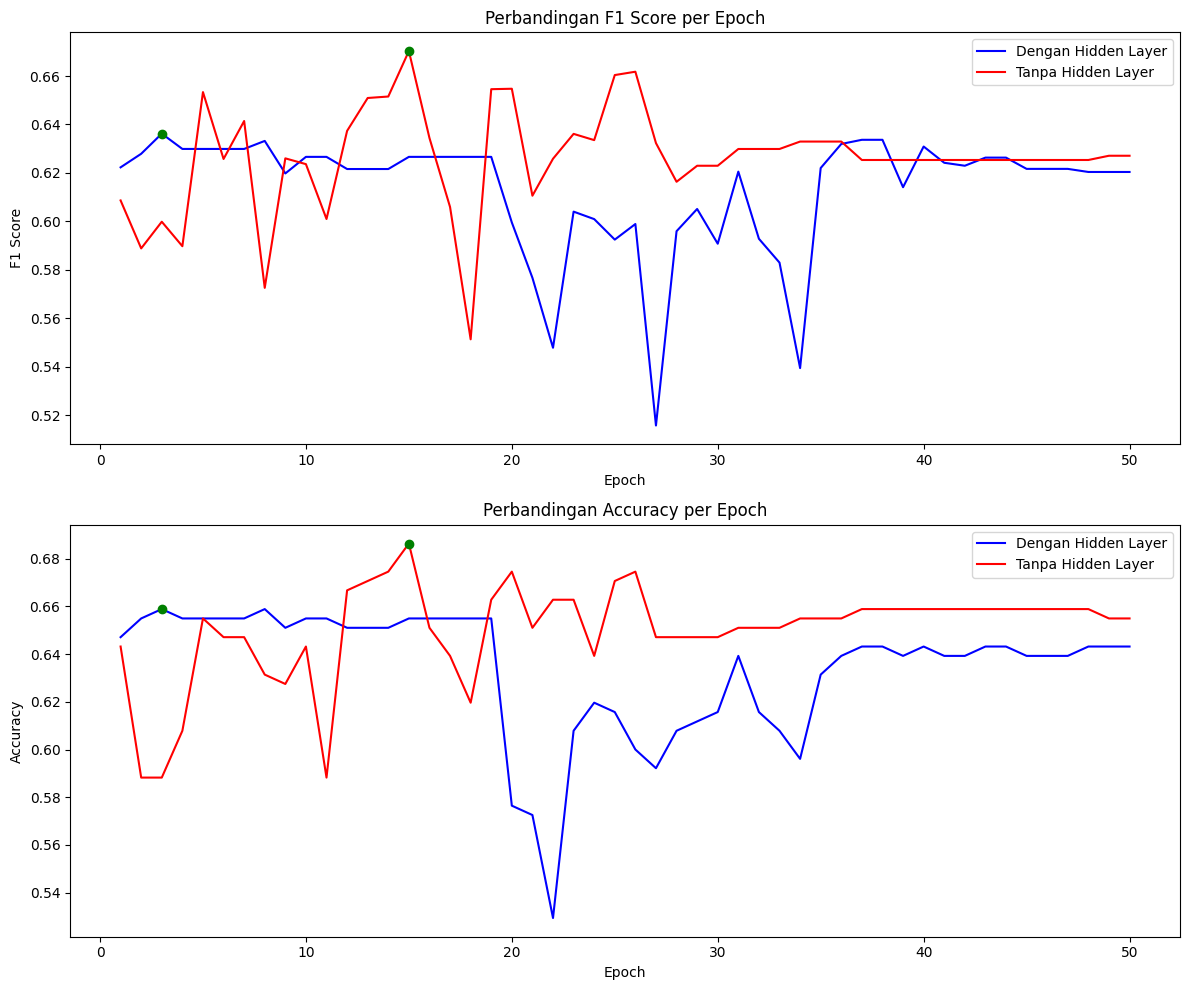

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df_with_hidden = pd.read_csv('./training_results_with_hidden.csv')
df_without_hidden = pd.read_csv('./training_results_without_hidden.csv')

# Grafik perbandingan
plt.figure(figsize=(12, 10))

# Grafik 1: Perbandingan F1 Score
plt.subplot(2, 1, 1)
plt.plot(df_with_hidden['Epoch'], df_with_hidden['Validation F1'], label="Dengan Hidden Layer", color='blue')
plt.plot(df_without_hidden['Epoch'], df_without_hidden['Validation F1'], label="Tanpa Hidden Layer", color='red')

# Menambahkan titik merah pada F1 Score tertinggi
max_f1_with_hidden = df_with_hidden['Validation F1'].max()
max_f1_epoch_with_hidden = df_with_hidden['Epoch'][df_with_hidden['Validation F1'].idxmax()]
plt.scatter(max_f1_epoch_with_hidden, max_f1_with_hidden, color='green', zorder=5)  

max_f1_without_hidden = df_without_hidden['Validation F1'].max()
max_f1_epoch_without_hidden = df_without_hidden['Epoch'][df_without_hidden['Validation F1'].idxmax()]
plt.scatter(max_f1_epoch_without_hidden, max_f1_without_hidden, color='green', zorder=5)  

plt.title('Perbandingan F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Grafik 2: Perbandingan Accuracy
plt.subplot(2, 1, 2)
plt.plot(df_with_hidden['Epoch'], df_with_hidden['Validation Accuracy'], label="Dengan Hidden Layer", color='blue')
plt.plot(df_without_hidden['Epoch'], df_without_hidden['Validation Accuracy'], label="Tanpa Hidden Layer", color='red')

# Menambahkan titik merah pada Accuracy tertinggi
max_acc_with_hidden = df_with_hidden['Validation Accuracy'].max()
max_acc_epoch_with_hidden = df_with_hidden['Epoch'][df_with_hidden['Validation Accuracy'].idxmax()]
plt.scatter(max_acc_epoch_with_hidden, max_acc_with_hidden, color='green', zorder=5)  

max_acc_without_hidden = df_without_hidden['Validation Accuracy'].max()
max_acc_epoch_without_hidden = df_without_hidden['Epoch'][df_without_hidden['Validation Accuracy'].idxmax()]
plt.scatter(max_acc_epoch_without_hidden, max_acc_without_hidden, color='green', zorder=5)  

plt.title('Perbandingan Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()

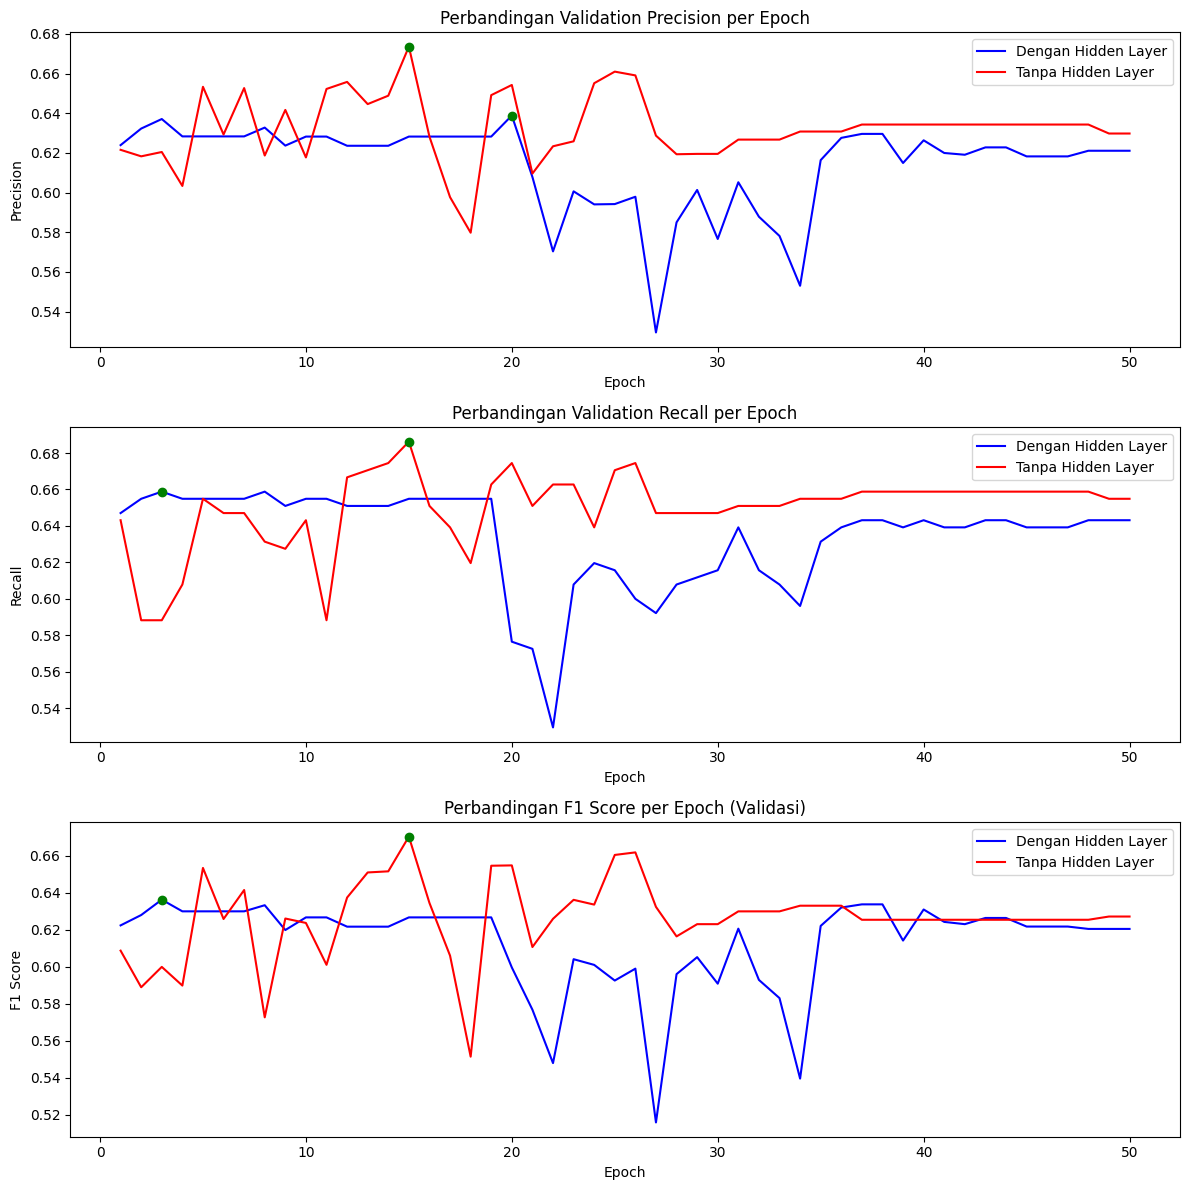

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df_with_hidden = pd.read_csv('./training_results_with_hidden.csv')
df_without_hidden = pd.read_csv('./training_results_without_hidden.csv')

# Grafik perbandingan
plt.figure(figsize=(12, 12))

# Grafik 1: Perbandingan Validation Precision
plt.subplot(3, 1, 1)
plt.plot(df_with_hidden['Epoch'], df_with_hidden['Validation Precision'], label="Dengan Hidden Layer", color='blue')
plt.plot(df_without_hidden['Epoch'], df_without_hidden['Validation Precision'], label="Tanpa Hidden Layer", color='red')

# Menambahkan titik merah pada Precision tertinggi
max_precision_with_hidden = df_with_hidden['Validation Precision'].max()
max_precision_epoch_with_hidden = df_with_hidden['Epoch'][df_with_hidden['Validation Precision'].idxmax()]
plt.scatter(max_precision_epoch_with_hidden, max_precision_with_hidden, color='green', zorder=5)  

max_precision_without_hidden = df_without_hidden['Validation Precision'].max()
max_precision_epoch_without_hidden = df_without_hidden['Epoch'][df_without_hidden['Validation Precision'].idxmax()]
plt.scatter(max_precision_epoch_without_hidden, max_precision_without_hidden, color='green', zorder=5)  

plt.title('Perbandingan Validation Precision per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Grafik 2: Perbandingan Validation Recall
plt.subplot(3, 1, 2)
plt.plot(df_with_hidden['Epoch'], df_with_hidden['Validation Recall'], label="Dengan Hidden Layer", color='blue')
plt.plot(df_without_hidden['Epoch'], df_without_hidden['Validation Recall'], label="Tanpa Hidden Layer", color='red')

# Menambahkan titik merah pada Recall tertinggi
max_recall_with_hidden = df_with_hidden['Validation Recall'].max()
max_recall_epoch_with_hidden = df_with_hidden['Epoch'][df_with_hidden['Validation Recall'].idxmax()]
plt.scatter(max_recall_epoch_with_hidden, max_recall_with_hidden, color='green', zorder=5)  

max_recall_without_hidden = df_without_hidden['Validation Recall'].max()
max_recall_epoch_without_hidden = df_without_hidden['Epoch'][df_without_hidden['Validation Recall'].idxmax()]
plt.scatter(max_recall_epoch_without_hidden, max_recall_without_hidden, color='green', zorder=5)  

plt.title('Perbandingan Validation Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Grafik 3: Perbandingan F1 Score (Sudah Ada)
plt.subplot(3, 1, 3)
plt.plot(df_with_hidden['Epoch'], df_with_hidden['Validation F1'], label="Dengan Hidden Layer", color='blue')
plt.plot(df_without_hidden['Epoch'], df_without_hidden['Validation F1'], label="Tanpa Hidden Layer", color='red')

# Menambahkan titik merah pada F1 Score tertinggi
max_f1_with_hidden = df_with_hidden['Validation F1'].max()
max_f1_epoch_with_hidden = df_with_hidden['Epoch'][df_with_hidden['Validation F1'].idxmax()]
plt.scatter(max_f1_epoch_with_hidden, max_f1_with_hidden, color='green', zorder=5)  

max_f1_without_hidden = df_without_hidden['Validation F1'].max()
max_f1_epoch_without_hidden = df_without_hidden['Epoch'][df_without_hidden['Validation F1'].idxmax()]
plt.scatter(max_f1_epoch_without_hidden, max_f1_without_hidden, color='green', zorder=5)  

plt.title('Perbandingan F1 Score per Epoch (Validasi)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()

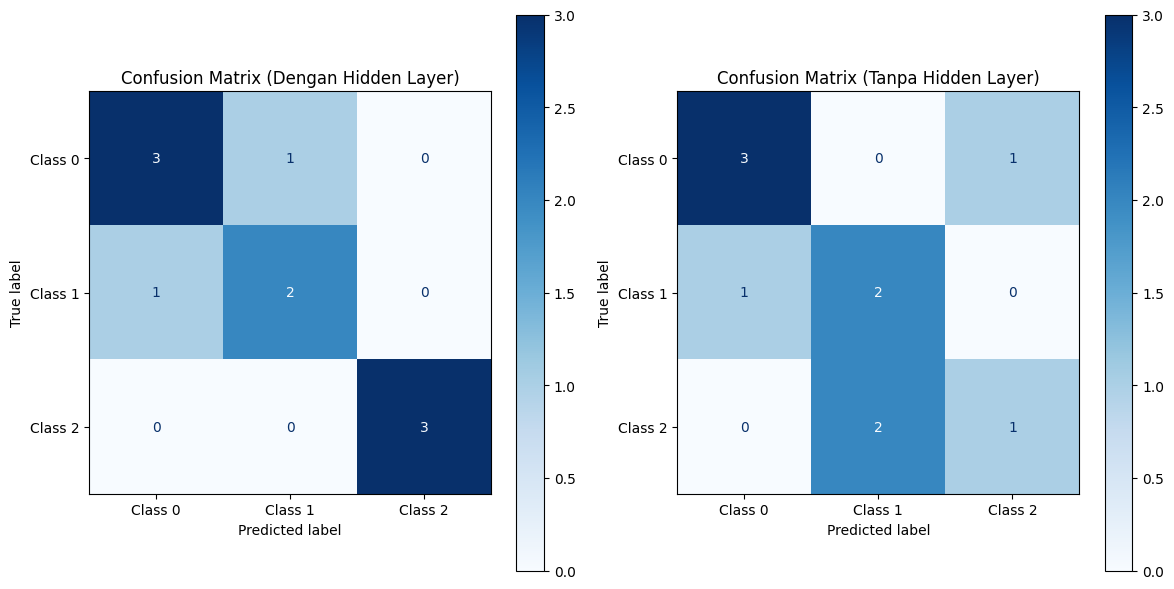

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0]  # Label aktual dengan 3 kelas
y_pred_with_hidden = [0, 1, 2, 0, 1, 2, 0, 0, 2, 1]  # Prediksi dengan hidden layer
y_pred_without_hidden = [0, 0, 1, 0, 1, 2, 0, 1, 1, 2]  # Prediksi tanpa hidden layer

# Hitung Confusion Matrix untuk model dengan hidden layer
cm_with_hidden = confusion_matrix(y_true, y_pred_with_hidden)
disp_with_hidden = ConfusionMatrixDisplay(confusion_matrix=cm_with_hidden, display_labels=['Class 0', 'Class 1', 'Class 2'])

# Hitung Confusion Matrix untuk model tanpa hidden layer
cm_without_hidden = confusion_matrix(y_true, y_pred_without_hidden)
disp_without_hidden = ConfusionMatrixDisplay(confusion_matrix=cm_without_hidden, display_labels=['Class 0', 'Class 1', 'Class 2'])

# Membuat grafik
plt.figure(figsize=(12, 6))

# Plot Confusion Matrix untuk model dengan hidden layer
plt.subplot(1, 2, 1)
disp_with_hidden.plot(cmap='Blues', ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix (Dengan Hidden Layer)')

# Plot Confusion Matrix untuk model tanpa hidden layer
plt.subplot(1, 2, 2)
disp_without_hidden.plot(cmap='Blues', ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix (Tanpa Hidden Layer)')

# Menampilkan grafik
plt.tight_layout()
plt.show()

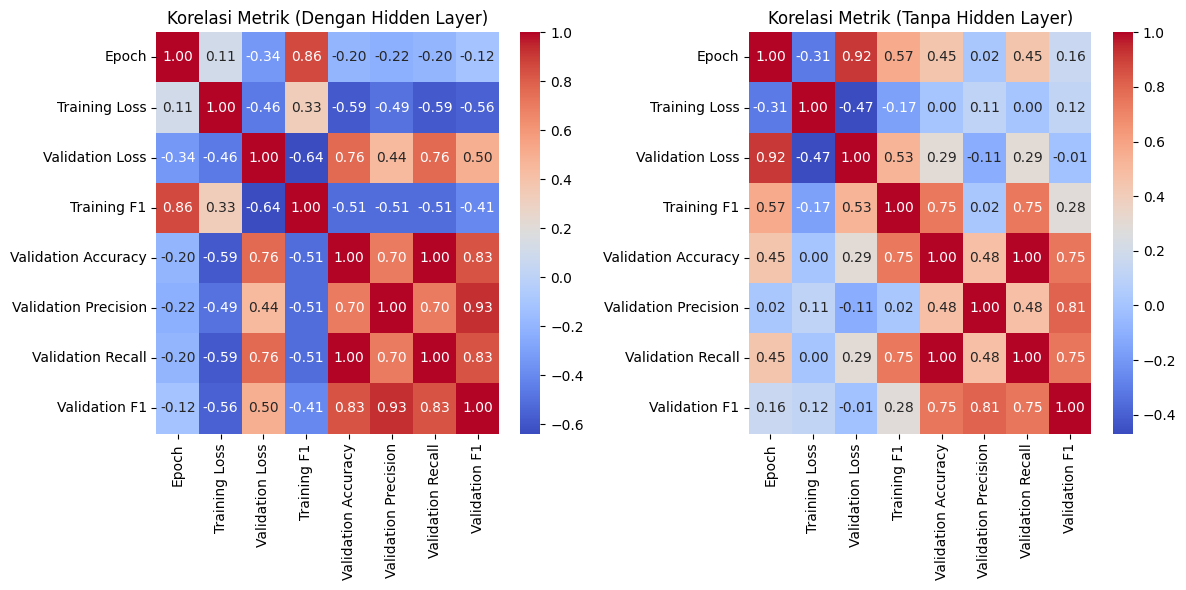

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Memuat hasil pelatihan dari file CSV
df_with_hidden = pd.read_csv('./training_results_with_hidden.csv')
df_without_hidden = pd.read_csv('./training_results_without_hidden.csv')

# Pilih kolom yang ingin dianalisis korelasinya
metrics_with_hidden = df_with_hidden[['Epoch', 'Training Loss', 'Validation Loss', 'Training F1', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1']]
metrics_without_hidden = df_without_hidden[['Epoch', 'Training Loss', 'Validation Loss', 'Training F1', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1']]

# Menghitung korelasi untuk model dengan hidden layer
corr_with_hidden = metrics_with_hidden.corr()

# Menghitung korelasi untuk model tanpa hidden layer
corr_without_hidden = metrics_without_hidden.corr()

# Membuat figure untuk heatmap
plt.figure(figsize=(12, 6))

# Heatmap untuk model dengan hidden layer
plt.subplot(1, 2, 1)
sns.heatmap(corr_with_hidden, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Korelasi Metrik (Dengan Hidden Layer)')

# Heatmap untuk model tanpa hidden layer
plt.subplot(1, 2, 2)
sns.heatmap(corr_without_hidden, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Korelasi Metrik (Tanpa Hidden Layer)')

# Menampilkan grafik
plt.tight_layout()
plt.show()